<a href="https://colab.research.google.com/github/Lucia1009/TFG-Plataforma-para-la-prediccion-de-potencia-electrica-generada-en-parques-eolicos/blob/desarrollo/modelos/Series_temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   SVM
*   *ARIMA/SARIMA*
*   Redes neuronales:

  *   TLNN, SANN
  *   RNN (redes neuronales recurrentes)
  *   LSTM (Memoria a corto plazo. También es recurrente)
  *   CNN (Redes neuronales convolucionales)









                  
                  
                  

In [20]:
!pip install dash -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import dash
from dash import Dash, html, dcc, Input, Output
import plotly.express as px
import plotly.graph_objects as go

In [2]:
def cargar_datos():

  from google.colab import drive
  drive.mount('/content/drive')

  df1=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_aa.csv', delimiter=";",decimal=".",skiprows = [1])
  df2=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ab.csv', delimiter=";",decimal=".",skiprows = [1])
  df3=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ac.csv', delimiter=";",decimal=".",skiprows = [1])
  df4=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ad.csv', delimiter=";",decimal=".",skiprows = [1])
  df5=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ae.csv', delimiter=";",decimal=".",skiprows = [1])
  df6=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_af.csv', delimiter=";",decimal=".",skiprows = [1])
  df7=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ag.csv', delimiter=";",decimal=".",skiprows = [1])
  df8=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ah.csv', delimiter=";",decimal=".",skiprows = [1])
  df9=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ai.csv', delimiter=";",decimal=".",skiprows = [1])
  df10=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_aj.csv', delimiter=";",decimal=".",skiprows = [1])
  df11=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ak.csv', delimiter=";",decimal=".",skiprows = [1])
  df12=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_al.csv', delimiter=";",decimal=".",skiprows = [1])
  df13=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_am.csv', delimiter=";",decimal=".",skiprows = [1])
  df14=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_an.csv', delimiter=";",decimal=".",skiprows = [1])

  df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14])

  return df

df=cargar_datos()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def filtrar_datos(df):
  df.head()

  ## TIEMPO/RÉGIMEN ESTACIONARIO
  # Filtro para el régimen estacionario
  datos=df[(df['TIME'] % 600==540)]

  #Reseteo el índice y quito la primera fila
  datos = datos.reset_index(drop=True)
  datos=datos.drop(0)

  ## WD
  #Obtener la dirección wd mímina y máxima de datos_filtrado
  datos = datos[datos['wd'] >= 0]
  datos = datos[datos['wd'] < 360]

  ## WF_POWER
  # datos_filtrado = datos_filtrado[datos_filtrado['WF_Power'] >= 0]
  datos[datos['WF_Power'] < 0] = 0  # Mejores resultados

  ## WS
  # datos_filtrado = datos_filtrado[datos_filtrado['ws'] >= 0]
  datos[datos['ws'] < 0] = 0  # Mejores resultados

  datos_filtrado=datos[['ws', 'wd', 'WF_Power_SP', 'WF_Power']]

  return datos_filtrado

datos_filtrado=filtrar_datos(df)

In [4]:
# fig = go.Figure()

# fig.add_trace(go.Scatter(x=datos_filtrado['TIME'], y=datos_filtrado['WF_Power_SP'],
#                     mode='markers',
#                     name='WF_Power'))

# fig.update_layout(
#     xaxis=dict(
#         rangeslider=dict(
#             visible=True
#         ),
#         type="linear"
#     )
# )

# fig.show()


In [5]:
# # Genera columnas con las variables de tiempo -1 y +1
# def obtener_momentos_tiempo(datos, salto_pasado=1, salto_futuro=1):
#   vars=datos.columns
#   cols, name_cols = [],[]

#   for i in range(salto_pasado,0,-1):
#     cols.append(datos.shift(i))
#     name_cols += [('%s(t-%d)' % (nom, i)) for nom in vars]
#   for i in range(0,salto_futuro):
#     cols.append(datos.shift(-i))
#     if i == 0:
#       name_cols += [('%s(t)' % (nom)) for nom in vars]
#     else:
#       name_cols += [('%s(t+%d)' % (nom, i)) for nom in vars]

#   res = pd.concat(cols, axis=1)
#   res.columns = name_cols
#   res.dropna(inplace=True)

#   return res
# salto_pasado=4
# salto_futuro=1
# momentos_tiempo=obtener_momentos_tiempo(datos_filtrado, salto_pasado, salto_futuro)
# momentos_tiempo.head()

In [6]:
# def datos_to_x_y(datos, salto):

#   if salto==1:
#     Y=datos['WF_Power(t)']
#     X=datos.drop(['WF_Power(t)'],axis=1)
#   else:
#     salto=salto-1
#     Y=datos[f'WF_Power(t-{salto})']
#     X=datos.drop([f'WF_Power(t-{salto})'],axis=1)

#   return X,Y



# def obtener_train_test(datos, salto, porcentaje=0.8):
#   train_size = int(len(datos) * porcentaje)
#   test_size = len(datos) - train_size
#   train, test = datos.iloc[0:train_size,:], datos.iloc[train_size:len(datos),:]

#   train_X, train_Y = datos_to_x_y(train, salto)
#   test_X, test_Y = datos_to_x_y(test, salto)

#   # Normalizamos los datos
#   scaler = MinMaxScaler(feature_range=(0, 1))
#   train_X = scaler.fit_transform(train_X)
#   test_X = scaler.transform(test_X)

#   train_X = np.reshape(train_X, (train_X.shape[0], salto, train_X.shape[1]))
#   test_X = np.reshape(test_X, (test_X.shape[0], salto, test_X.shape[1]))

#   return train_X, train_Y, test_X, test_Y, scaler

# train_X, train_Y, test_X, test_Y, scaler = obtener_train_test(momentos_tiempo, salto_futuro)

In [7]:
# # Creamos el modelo
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(64))
# model.add(Dense(32))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam', metrics=['R2Score','mae', 'mse'])

# history = model.fit(train_X, train_Y, epochs=20, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

# model.evaluate(test_X, test_Y)

In [8]:
# from numpy import concatenate
# from pandas import concat

# yhat = model.predict(test_X)

# # Añadimos una nueva dimension a yhat
# yhat = yhat.reshape((yhat.shape[0], 1, yhat.shape[1]))

# # Eliminamos la dimension del medio en test_X[:, 1:]
# test_X_nuevo=test_X[:, 0, 1:]

# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:,:,1:]), axis=2) #Concatenamos los datos con la misma dimension
# inv_yhat = inv_yhat.reshape(inv_yhat.shape[0], inv_yhat.shape[2]) # Reajustamos los datos para que coincidan con lo que espera el scaler
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]

# # invert scaling for actual
# test_y = test_Y.values.reshape((len(test_Y), 1))
# inv_y = concatenate((test_y, test_X_nuevo), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

# print(len(test_Y))
# print(len(yhat))

# fig = go.Figure()

# fig.add_trace(go.Scatter( y=inv_yhat,
#                     mode='markers',
#                     name='WF_Power_PREDICHA', marker_color='red'))

# fig.add_trace(go.Scatter( y=inv_y,
#                     mode='markers',
#                     name='WF_Power_REAL', marker_color='blue'))

# fig.update_layout(
#     xaxis=dict(
#         rangeslider=dict(
#             visible=True
#         ),
#         type="linear"
#     )
# )

# fig.show()

# # Guardar en un html la figura
# fig.write_html("serie_temporal.html")

![imagen](/content/drive/MyDrive/TFG/series temporales.jpg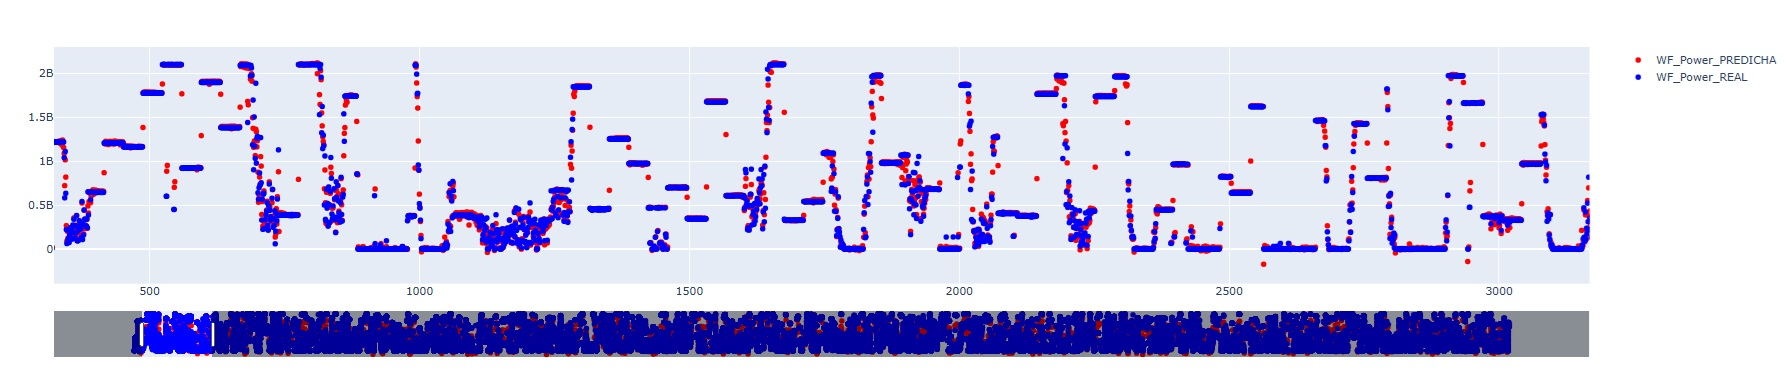)



---

# Prueba 2

In [9]:
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

train, val, test = train_val_test_split(datos_filtrado)

print(train.shape)
print(val.shape)
print(test.shape)

(222688, 4)
(27836, 4)
(27837, 4)


In [10]:
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 24    # Registros de 240 min anteriores a la entrada
OUTPUT_LENGTH = 5    # El modelo va a predecir 10 min a futuro

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(train.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(val.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(test.values, INPUT_LENGTH, OUTPUT_LENGTH)

print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (222659, 24, 4), y_tr: (222659, 5, 1)
Set de validación - x_vl: (27807, 24, 4), y_vl: (27807, 5, 1)
Set de prueba - x_ts: (27808, 24, 4), y_ts: (27808, 5, 1)


In [11]:
def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Create a scaler for input features
    scaler_x = MinMaxScaler(feature_range=(-1, 1))

    # Scale the input features
    x_tr_s = scaler_x.fit_transform(data_input['x_tr'].reshape(-1, NFEATS)).reshape(data_input['x_tr'].shape)
    x_vl_s = scaler_x.transform(data_input['x_vl'].reshape(-1, NFEATS)).reshape(data_input['x_vl'].shape)
    x_ts_s = scaler_x.transform(data_input['x_ts'].reshape(-1, NFEATS)).reshape(data_input['x_ts'].shape)

    # Create a scaler for output (target) variable
    scaler_y = MinMaxScaler(feature_range=(-1, 1))

    # Scale the output variable
    y_tr_s = scaler_y.fit_transform(data_input['y_tr'].reshape(-1, 1)).reshape(data_input['y_tr'].shape)
    y_vl_s = scaler_y.transform(data_input['y_vl'].reshape(-1, 1)).reshape(data_input['y_vl'].shape)
    y_ts_s = scaler_y.transform(data_input['y_ts'].reshape(-1, 1)).reshape(data_input['y_ts'].shape)

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scaler_x, scaler_y

data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}
data_s, scaler_x, scaler_y = escalar_dataset(data_in)
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [29]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

N_UNITS = 128
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))
modelo.compile(optimizer=RMSprop(), loss='mse', metrics=['mae', 'mse', 'R2Score'])
modelo.summary()


EPOCHS = 10
BATCH_SIZE = 256

historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

#guardar el modelo
modelo.save('modelo_1_tiempo.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 256)                 │         267,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 268,549 (1.02 MB)

 Trainable params: 268,549 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
870/870 - 254s - 292ms/step - R2Score: 0.7871 - loss: 0.0896 - mae: 0.1708 - mse: 0.0896 - val_R2Score: 0.8170 - val_loss: 0.0779 - val_mae: 0.1620 - val_mse: 0.0779
Epoch 2/10
870/870 - 256s - 294ms/step - R2Score: 0.8082 - loss: 0.0807 - mae: 0.1601 - mse: 0.0807 - val_R2Score: 0.8277 - val_loss: 0.0733 - val_mae: 0.1455 - val_mse: 0.0733
Epoch 3/10
870/870 - 256s - 294ms/step - R2Score: 0.8157 - loss: 0.0776 - mae: 0.1574 - mse: 0.0776 - val_R2Score: 0.8320 - val_loss: 0.0715 - val_mae: 0.1507 - val_mse: 0.0715
Epoch 4/10
870/870 - 271s - 311ms/step - R2Score: 0.8198 - loss: 0.0759 - mae: 0.1555 - mse: 0.0759 - val_R2Score: 0.8287 - val_loss: 0.0729 - val_mae: 0.1625 - val_mse: 0.0729
Epoch 5/10
870/870 - 254s - 292ms/step - R2Score: 0.8228 - loss: 0.0746 - mae: 0.1534 - mse: 0.0746 - val_R2Score: 0.8350 - val_loss: 0.0702 - val_mae: 0.1550 - val_mse: 0.0702
Epoch 6/10
870/870 - 268s - 308ms/step - R2Score: 0.8253 - loss: 0.0735 - mae: 0.1516 - mse: 0.0735 - val_R2Score: 

In [23]:
modelo=tf.keras.models.load_model('modelo_1_tiempo.keras')
modelo.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 24, 64)              │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,028 (398.55 KB)

 Trainable params: 51,013 (199.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,015 (199.28 KB)

In [24]:
# modelo.evaluate returns loss value and specified metrics
loss_ts, mae_ts, mse_ts, r2_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Print the comparison of performance metrics
print('Comparación desempeños:')
print(f'  RMSE test:\t {mse_ts}')
print(f'  MAE test:\t {mae_ts}')
print(f'  R2 test:\t {r2_ts}')

Comparación desempeños:
  RMSE test:	 0.07629849016666412
  MAE test:	 0.15759235620498657
  R2 test:	 0.8186488151550293


In [25]:
from sklearn.metrics import r2_score

def desescalar(x_scaled, y_scaled, scaler_x, scaler_y, num_features=24):

    # Inverse transform the relevant features using scaler_x
    x_descaled = scaler_x.inverse_transform(x_scaled.reshape(-1, data_in['x_tr'].shape[2])).reshape(data_in['x_ts'].shape)

    # Inverse transform y_scaled using scaler_y
    y_descaled = scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

    return x_descaled, y_descaled

def predecir(x, model, scaler_x, scaler_y):

   # Get scaled predictions
    y_pred_s = model.predict(x, verbose=0)

    # Descale predictions and targets
    _, y_pred = desescalar(x, y_pred_s, scaler_x, scaler_y)

    return y_pred

y_ts_pred = predecir(x_ts_s, modelo, scaler_x, scaler_y)

_, y_ts_reshaped = desescalar(x_ts_s, y_ts_s, scaler_x, scaler_y)

# Calculate R2 score
r2 = r2_score(y_ts_reshaped, y_ts_pred)

print(f"R2 Score: {r2}")

print(y_ts_reshaped.shape)
print(y_ts_pred.shape)
print(y_ts_reshaped)
print(y_ts_pred)

R2 Score: 0.8186469173724754
(139040,)
(139040,)
[29126779.9 29149857.3 29122607.8 ... 46876226.  46865650.1 46871708. ]
[29073346. 31188670. 31071806. ... 46247564. 45228572. 44944312.]


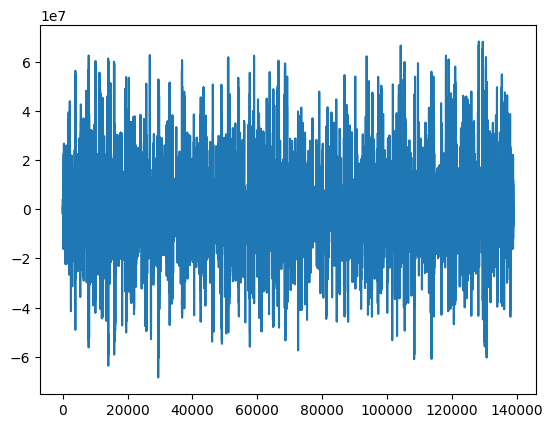

In [26]:
N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [27]:
# Imprimo las métricas de las predicciones
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error

r2 = r2_score(y_ts_reshaped, y_ts_pred)
rmse = math.sqrt(mean_squared_error(y_ts_reshaped, y_ts_pred))
mae = mean_absolute_error(y_ts_reshaped, y_ts_pred)
max_error = max_error(y_ts_reshaped, y_ts_pred)

print('Comparación desempeños:')
print(f'  RMSE test:\t\t {rmse}')
print(f'  MAE test:\t\t {mae}')
print(f'  R2 test:\t\t {r2}')
print(f'  Max Error test:\t {max_error}')

Comparación desempeños:
  RMSE test:		 9734828.93407305
  MAE test:		 5553991.093118189
  R2 test:		 0.8186469173724754
  Max Error test:	 68423072.0


# Gráfica de resultado

In [28]:
"""Gráfica con los valores reales y los predichos"""
fig = go.Figure()

fig.add_trace(go.Scatter(y=y_ts_reshaped, mode='lines', marker=dict(color='red'), name='Real'))
fig.add_trace(go.Scatter(y=y_ts_pred, mode='lines', opacity=0.7, marker=dict(color='blue'), name='Predicción'))

fig.show()